# PADL Week 7 Practical including solutions

This practical is all about ReLU MLPs. These are still an amazingly useful tool and can be used to solve many real problems (and are still actively used in state-of-the-art research).

We'll start by revising the application of an MLP to the breast cancer dataset, as in previous practicals. Then you'll try fitting a ReLU MLP to a given function (a sinusoid) to get an intuition for how they work. Finally, you'll try to classify a highly nonlinear 2D, two class dataset using a ReLU MLP. At the end of each exercise there are some tasks for you to do.

## 1. MLP for breast cancer data revisited

I've given you the code to load the dataset and train a single hidden layer MLP. Read and understand the code, click through and then try the tasks at the end.

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numpy import pi
import torch.nn as nn

Load the dataset and convert to PyTorch tensors

In [2]:
training_size = 400

data = np.genfromtxt("data/wdbc.data", delimiter=",", missing_values="?")
data = data[~np.isnan(data).any(axis=1)]

# Convert labels to binary 0/1 classes as expected by PyTorch
y_01 = np.array([0 if x == 2 else 1 for x in data[:, -1]])

X = data[:, 1:-1]  # ignore first column and omit class variable at the end

In [3]:
# Split train/test and convert to PyTorch tensors
X_train_tensor = torch.from_numpy(np.float32(X[:training_size]))
Y_train_tensor = torch.from_numpy(np.float32(y_01[:training_size])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(X[training_size:]))
Y_test_tensor = torch.from_numpy(np.float32(y_01[training_size:])).unsqueeze(1)

Let's make sure that we understand the structure of our data. Let's start by printing the shapes of the training data inputs and labels (always a good idea!)

In [4]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)

torch.Size([400, 9])
torch.Size([400, 1])


So, our training data comprises 400 samples. Each sample comprises a 9 dimensional input and a binary label. In other words `X_train_tensor[i,:]` is the 9D input for training sample `i` and `Y_train_tensor[i]` contains either a 0 or 1 to indicate which class it belongs to.

### Define a single hidden layer MLP

We will now define a simple MLP that we will use to solve this problem. This MLP will allow us to specify the input size and the number of neurons in the hidden layer when we instantiate it. It will contain one hidden layer followed by ReLU activation. Since this is a binary classification problem, the output layer will map the output of the hidden layer to a single output which will represent the probability of one of the classes. Since we need the output to represent a probability, we will use sigmoid to map the unconstrained value to a value between 0 and 1.

In [5]:
class MLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        # Call superclass constructor
        super(MLP, self).__init__()
        # Initialise components of model:
        # 1. First linear layer (hidden layer)
        self.linear1 = nn.Linear(inputSize, hiddenSize)
        # 2. ReLU layer
        self.relu = nn.ReLU()
        # 3. Second linear layer (output layer)
        self.linear2 = nn.Linear(hiddenSize, 1)
        # 4. Sigmoid layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the model:
        # x has shape batch x inputSize
        # HIDDEN LAYER
        # 1. Apply linear layer to input
        y = self.linear1(x)
        # y has shape batch x 16
        # 2. Apply ReLU to output of linear layer
        y = self.relu(y)
        # OUTPUT LAYER
        # 3. Apply linear layer to output of hidden layer
        y = self.linear2(y)
        # y has shape batch x 1
        # 4. Apply sigmoid to output of linear layer
        y = self.sigmoid(y)
        return y

Let's just remind ourselves how this model is actually used. First, we want to instantiate it. At this point, the learnable weights and biases are initialised with random values. If you've run some learning and want to start again from scratch, you need to rerun this line, otherwise the weights will be preserved from your previous training.

In [6]:
# Instantiate MLP with 9 channel input and 16 neuron hidden layer
model = MLP(9, 16)

Now let's just check that we understand the shapes of inputs and outputs to the model. Let's create some random input and put it through the model.

In [7]:
x = torch.randn(100, 9)
y = model(x)
print(y.shape)
print(torch.min(y))
print(torch.max(y))

torch.Size([100, 1])
tensor(0.3198, grad_fn=<MinBackward1>)
tensor(0.5060, grad_fn=<MaxBackward1>)


The first dimension of `x` is the batch size. We are allowed to pass many inputs through a model in parallel and this first dimension (100 in this case) represents this. The second dimension is the size of the input - in this case we have 9D input. The output has shape $100\times 1$, i.e. a scalar probability for each of the 100 inputs. We can see that the values in `y` lie between 0 and 1.

### Training the model

We're now ready to try training the model. We need to define a loss function, set up the optimiser and then run the training loop. We will use binary cross entropy loss and straightforward gradient descent. For each iteration (="epoch" because we process the entire training set in each operation - this will be different when we come to using minibatches later) of the training loop, we simply put the inputs through our model, get probabilities out (`y_predict`) and put these into the loss function to compare against the binary labels. We then perform backprop and take a gradient descent step.

In [8]:
epochs = 5000

# Instantiate loss function (binary cross entropy loss - sigmoid applied inside model)
criterion = torch.nn.BCELoss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.1)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = model(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict, Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 0.8302181363105774
epoch 200, loss 0.14347055554389954
epoch 400, loss 0.09945181757211685
epoch 600, loss 0.08739921450614929
epoch 800, loss 0.08278954774141312
epoch 1000, loss 0.07845012098550797
epoch 1200, loss 0.07499206066131592
epoch 1400, loss 0.07144421339035034
epoch 1600, loss 0.06819625198841095
epoch 1800, loss 0.06473933905363083
epoch 2000, loss 0.0626792386174202
epoch 2200, loss 0.0594087652862072
epoch 2400, loss 0.056172341108322144
epoch 2600, loss 0.05288343131542206
epoch 2800, loss 0.050672825425863266
epoch 3000, loss 0.045906856656074524
epoch 3200, loss 0.04182083159685135
epoch 3400, loss 0.038372475653886795
epoch 3600, loss 0.034317437559366226
epoch 3800, loss 0.030804498121142387
epoch 4000, loss 0.02546396665275097
epoch 4200, loss 0.023992231115698814
epoch 4400, loss 0.02213256061077118
epoch 4600, loss 0.020641488954424858
epoch 4800, loss 0.019087670370936394


### Evaluating our model

Hopefully, the loss gradually reduced while your model trained. This is promising but the loss value is a bit hard to interpret. Let's now calculate the percentage correct classification on both the training and test sets. To convert the estimated probabilities into hard classifications, we simply threshold against 0.5. We can then compare the predictions against the actual labels.

In [9]:
# Pass training set set through model
y_predict = model(X_train_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict > 0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_train_tensor).float().sum()
print(
    "Percent training set correctly classified: {:.2f}%".format(
        100 * correct / training_size
    )
)

# Pass test set through model
y_predict = model(X_test_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict > 0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_test_tensor).float().sum()
print(
    "Percent test set correctly classified: {:.2f}%".format(
        100 * correct / X_test_tensor.shape[0]
    )
)

Percent training set correctly classified: 99.75%
Percent test set correctly classified: 97.53%


Depending on your random seed, performance should be in the high 90s and performance on the test set will be slightly different, possibly in either direction.

### A note of caution: bias

When we split the dataset into a training and test set, we simply took the first 400 samples as training data and the remainder as test data. It is always a good idea to check whether your dataset is biased and, if so, whether the bias is the same in both the training and test sets.

In [10]:
print(
    "Percent of train set with class 1: {:.2f}".format(
        Y_train_tensor.sum() / Y_train_tensor.shape[0]
    )
)
print(
    "Percent of test set with class 1: {:.2f}".format(
        Y_test_tensor.sum() / Y_test_tensor.shape[0]
    )
)

Percent of train set with class 1: 0.43
Percent of test set with class 1: 0.24


As you can see, our dataset is slightly biased (more class 0 than class 1). However, the bias is worse in the test set than training set. This might be bad.

If your goal is to maximise performance for any unseen test set, then ideally the training set would be unbiased. There are various strategies you could use for this. One option is to weight the loss by inverse class frequency. Another is to use a weighted sampling such that samples from the underrepresented class get used in training more often. But we won't worry about this for now.

If your goal is to maximise performance on the given test set then we would like the bias to be the same in both training and test set. One strategy to achieve this is to randomly shuffle the data before splitting into training and test.

### Tasks

1. Apply the same random shuffle to `X` and `y_01` before splitting into train and test. Verify that this leads to the same (or very similar) bias in each dataset. Retrain your model. Does this change performance at all?
2. Experiment with a smaller MLP - i.e. reduce the number of hidden neurons. How small can you make it while still achieving good performance? If you make it really small, eventually it can't extract any useful information from the features in which case it will only learn the bias (i.e. it will just always predict the more common class and will be right with chance performance). Can you see this happening? What performance do you get?
3. Experiment with a deeper/and or wider MLP. i.e. either add additional hidden layers or use more neurons in the hidden layers. Does performance improve? Can you see "overfitting" at some point? (Where training loss goes to almost zero but test performance gets worse).
4. It's always a good idea to know how many trainable parameters your model has. You should always think about whether your training data is large enough to allow that many parameters to be learnt or if the model is too flexible (in which case it will easily overfit your training data but probably won't generalise). Do some googling to find out how to count the number of trainable parameters in your model.

## 2. Fitting a sinusoid with a ReLU MLP

As we've heard in lectures, machine learning is really just *function approximation*. In the next exercise we will literally try to approximate a given function. We will train an MLP to take one input, $x$, and approximately output $\sin(x)$. Working with a simple 1D function is nice as we can visualise what the network is learning (and you will see how exactly a ReLU MLP approximates a function).

### Create training data

We will uniformly sample 200 values of $x$ from $0$ to $2\pi$. The labels will simply be $\sin(x)$ for all these $x$ values. These will form our training data. We can plot $x$ against the labels to see the function we are trying to learn.

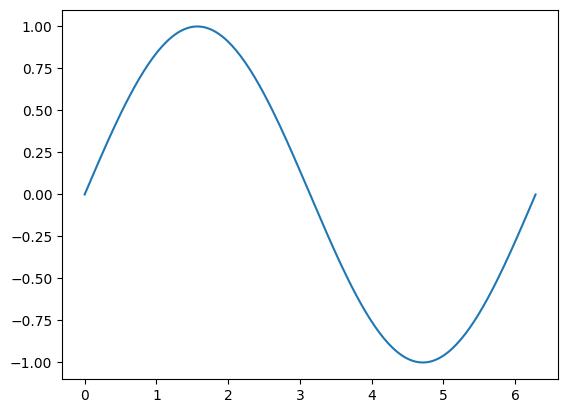

In [16]:
x = torch.linspace(0, 2 * pi, 200).unsqueeze(1)
label = torch.sin(x)
plt.plot(x, label)

### Tasks

1. Create a small MLP, `Sin()`, that takes one input, has a single hidden layer with 16 neurons and ReLU activation then an output layer with one output and no activation. This should require only small adaptation from the MLP used in exercise 1.
2. Decide on what loss function to use. The task here is regression not classification (you are predicting a continuous value). So don't use binary cross entropy loss.
3. Train your model. The training loop will be similar to exercise 1: pass the inputs `x` through your model, get predicted outputs, compare to `label` with your loss function and take a gradient descent step. Keep an eye on the loss value during training. If it's not reducing fast enough, increase learning rate (or try switching to the Adam optimiser). If it's diverging and going crazy, reduce the learning rate.
4. Once training has converged, plot the output of your network and compare it to the ground truth sinusoid. How well does it approximate the function? Can you see how ReLU is using straight line segments to approximate a curved function?
5. Repeat the above but make your network smaller (e.g. reduce the hidden neurons to 8). How good is the approximation now?


In [36]:
class Sin(nn.Module):
    def __init__(self, num_hidden_neurons):
        # Call superclass constructor
        super(Sin, self).__init__()
        # Initialise components of model:
        # 1. First linear layer (hidden layer)
        self.linear1 = nn.Linear(1, num_hidden_neurons)
        # 2. ReLU layer
        self.relu = nn.ReLU()
        # 3. Second linear layer (output layer)
        self.linear2 = nn.Linear(num_hidden_neurons, 1)

    def forward(self, x):
        # Forward pass through the model:
        # x has shape batch x inputSize
        # HIDDEN LAYER
        # 1. Apply linear layer to input
        y = self.linear1(x)
        # y has shape batch x 16
        # 2. Apply ReLU to output of linear layer
        y = self.relu(y)
        # OUTPUT LAYER
        # 3. Apply linear layer to output of hidden layer
        y = self.linear2(y)
        return y

In [37]:
sin_model = Sin(16)
epochs = 5000
criterion = torch.nn.L1Loss()
optim = torch.optim.Adam(sin_model.parameters(), lr=0.01)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = sin_model(x)
    # Compute BCE loss
    loss = criterion(y_predict, label)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 0.46513789892196655
epoch 200, loss 0.1230907216668129
epoch 400, loss 0.056638218462467194
epoch 600, loss 0.022454706951975822
epoch 800, loss 0.0228646919131279
epoch 1000, loss 0.018163083121180534
epoch 1200, loss 0.017800478264689445
epoch 1400, loss 0.020574050024151802
epoch 1600, loss 0.01961662620306015
epoch 1800, loss 0.018537288531661034
epoch 2000, loss 0.03472471237182617
epoch 2200, loss 0.017217714339494705
epoch 2400, loss 0.01855054311454296
epoch 2600, loss 0.019842786714434624
epoch 2800, loss 0.019268112257122993
epoch 3000, loss 0.0194522924721241
epoch 3200, loss 0.022208180278539658
epoch 3400, loss 0.033365532755851746
epoch 3600, loss 0.017348576337099075
epoch 3800, loss 0.016405070200562477
epoch 4000, loss 0.016538554802536964
epoch 4200, loss 0.023969711735844612
epoch 4400, loss 0.0233861543238163
epoch 4600, loss 0.016080768778920174
epoch 4800, loss 0.017061345279216766


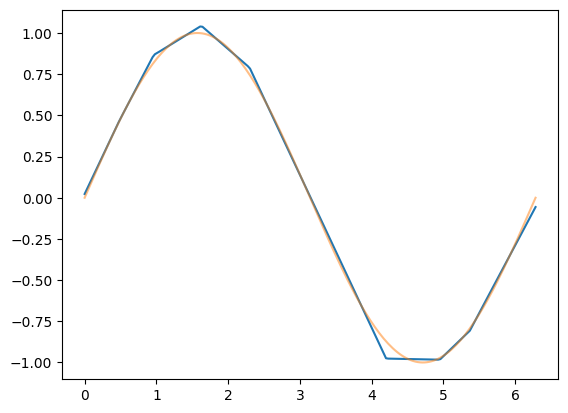

In [38]:
sin_predictions = sin_model(x)
plt.plot(x, sin_predictions.detach().numpy())
plt.plot(x, label, alpha=0.5)

In [45]:
sin_model = Sin(8)
epochs = 5000
criterion = torch.nn.L1Loss()
optim = torch.optim.Adam(sin_model.parameters(), lr=0.01)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = sin_model(x)
    # Compute BCE loss
    loss = criterion(y_predict, label)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 0.6457164287567139
epoch 200, loss 0.33755236864089966
epoch 400, loss 0.29102954268455505
epoch 600, loss 0.2767931818962097
epoch 800, loss 0.26806363463401794
epoch 1000, loss 0.27008751034736633
epoch 1200, loss 0.26352640986442566
epoch 1400, loss 0.2654462158679962
epoch 1600, loss 0.2690122425556183
epoch 1800, loss 0.2624204158782959
epoch 2000, loss 0.2646341621875763
epoch 2200, loss 0.2657832205295563
epoch 2400, loss 0.26408299803733826
epoch 2600, loss 0.2698485851287842
epoch 2800, loss 0.2629944682121277
epoch 3000, loss 0.2622155249118805
epoch 3200, loss 0.2630176246166229
epoch 3400, loss 0.2617895007133484
epoch 3600, loss 0.2654089629650116
epoch 3800, loss 0.2634550929069519
epoch 4000, loss 0.2641887962818146
epoch 4200, loss 0.2630436420440674
epoch 4400, loss 0.26929664611816406
epoch 4600, loss 0.26477229595184326
epoch 4800, loss 0.26188984513282776


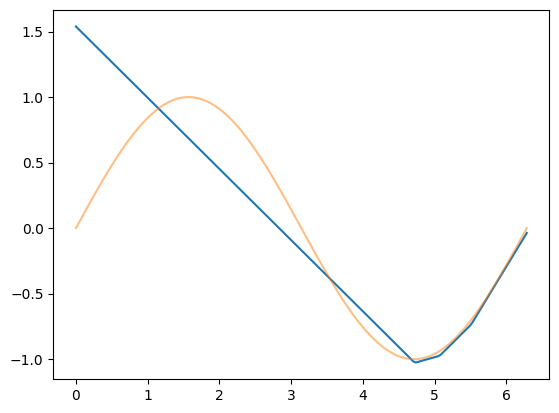

In [46]:
sin_predictions = sin_model(x)
plt.plot(x, sin_predictions.detach().numpy())
plt.plot(x, label, alpha=0.5)

## 3. Classifying the spiral dataset

The spiral dataset is a good example of a non-trivial binary classification problem. There are two input features for each data sample: the $x$ and $y$ coordinates of a point. The points belong to one of two classes, depending on which of the two interlocking spirals they lie on. The task is to create a small MLP that takes 2D input

### Generate the spiral dataset

The two classes are points lying on two spirals, rotated by 180 degrees and with some random noise added.

In [11]:
N = 400
training_size = 600
theta = np.sqrt(np.random.rand(N)) * 2 * pi

r_a = 2 * theta + pi
data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
x_a = data_a + np.random.randn(N, 2)

r_b = -2 * theta - pi
data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
x_b = data_b + np.random.randn(N, 2)

res_a = np.append(x_a, np.zeros((N, 1)), axis=1)
res_b = np.append(x_b, np.ones((N, 1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

X_train_tensor = torch.from_numpy(np.float32(res[:training_size, 0:2]))
Y_train_tensor = torch.from_numpy(np.float32(res[:training_size, 2])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(res[training_size:, 0:2]))
Y_test_tensor = torch.from_numpy(np.float32(res[training_size:, 2])).unsqueeze(1)

Visualise the dataset by plotting the points in the training set and colouring according to the class.

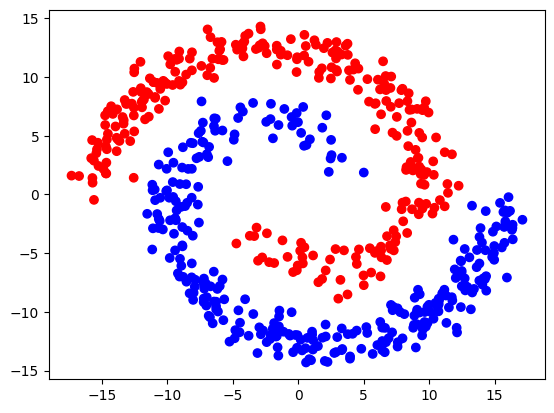

In [15]:
colors = np.where(Y_train_tensor.squeeze(1).numpy() == 0, "blue", "red")
plt.scatter(X_train_tensor[:, 0].numpy(), X_train_tensor[:, 1].numpy(), c=colors)

As you can see, it would not be possible linearly separate these two classes (you can't draw a straight line that divides the points into the two classes). However, we will see that a very small ReLU MLP can do this perfectly.

### Tasks

1. Instantiate a small classification MLP with 2 inputs, one hidden layer with 16 neurons and sigmoid activation on the output. You can reuse the `MLP()` class from earlier for this.
2. Train the MLP to classify the spiral points into two classes.
3. Evaluate by printing classification performance on training and test sets. Plot the spiral points for the test set as above, but colour them according to the class predicted by your MLP rather than the ground truth labels.
4. Let's visualise what the MLP has actually learnt. For any point in 2D space, the MLP assigns a probability. We can visualise this as an image. Use `torch.meshgrid` to create a grid of points over the range -15..15 in $x$ and $y$. Pass all those points through your model to get probabilities. Display the probabilities as an image using matplotlib's `imshow`. You should be able to see the *decision boundary* i.e. the point where the probability is 0.5 and it is separating the two classes. Can you see the influence of ReLU here?
5. As an extra challenge, try to draw the decision boundary over the top of the image as a contour plot. Hint: `skimage.measure.find_contours` will be helpful here.


In [158]:
spiral_model = MLP(2, 16)
epochs = 5000
criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(spiral_model.parameters(), lr=0.01)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = spiral_model(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict, Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 1.4647953510284424
epoch 200, loss 0.17196780443191528
epoch 400, loss 0.03582953289151192
epoch 600, loss 0.01774718426167965
epoch 800, loss 0.010457603260874748
epoch 1000, loss 0.006905128248035908
epoch 1200, loss 0.004879619460552931
epoch 1400, loss 0.0036289652343839407
epoch 1600, loss 0.0028033475391566753
epoch 1800, loss 0.0022258709650486708
epoch 2000, loss 0.0018021261785179377
epoch 2200, loss 0.0014835747424513102
epoch 2400, loss 0.0012369505129754543
epoch 2600, loss 0.001041462179273367
epoch 2800, loss 0.000883601896930486
epoch 3000, loss 0.0007550317095592618
epoch 3200, loss 0.0006458267453126609
epoch 3400, loss 0.0005555940442718565
epoch 3600, loss 0.00047992964391596615
epoch 3800, loss 0.000410778186051175
epoch 4000, loss 0.0003523143532220274
epoch 4200, loss 0.00030682640499435365
epoch 4400, loss 0.00026814022567123175
epoch 4600, loss 0.00023497884103562683
epoch 4800, loss 0.00020646680786740035


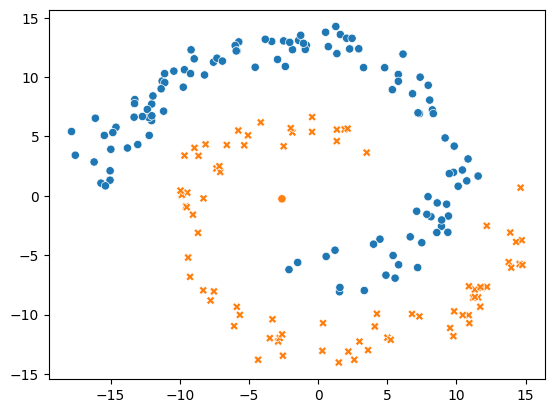

In [159]:
import seaborn as sns

spiral_predictions = spiral_model(X_test_tensor)
with torch.no_grad():
    colors = np.where(spiral_predictions.squeeze(1).numpy() < 0.5, "blue", "red")
markers = np.where(Y_test_tensor.squeeze(1).numpy() == 0, "x", "o")
sns.scatterplot(
    x=X_test_tensor[:, 0].numpy(),
    y=X_test_tensor[:, 1].numpy(),
    hue=colors,
    style=markers,
).legend().remove()

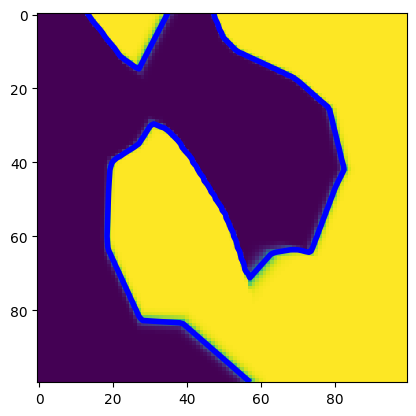

In [160]:
from skimage.measure import find_contours

x, y = torch.meshgrid(
    torch.linspace(-15, 15, 100), torch.linspace(-15, 15, 100), indexing="xy"
)
pairs = torch.cartesian_prod(torch.linspace(-15, 15, 100), torch.linspace(-15, 15, 100))
preds = spiral_model(pairs.unsqueeze(1))

with torch.no_grad():
    contours = find_contours(preds.reshape(100, 100).numpy())
    fig, ax = plt.subplots()
    ax.imshow(preds.reshape(100, 100))
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=4, c="blue")